In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure, morphology
from skimage.measure import regionprops
import math

In [2]:
from signature_detect.loader import Loader
from signature_detect.extractor import Extractor
from signature_detect.cropper import Cropper
from signature_detect.judger import Judger

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
image = cv.imread('./data/img_pech.jpg')
#image = cv2.resize(image, (int(500 * 1.2980769230769231), 500))
output = image.copy()

In [12]:
def check_printing(page, low_threshold, high_treshold):

    # uncomment for testing
    test = page.copy()
    
    # gray
    gray = cv.cvtColor(page, cv.COLOR_BGR2GRAY)

    # blur
    blur = cv.GaussianBlur(gray, (7, 7), 0)

    # поиск окружностей
    circles = cv.HoughCircles(blur, cv.HOUGH_GRADIENT, dp=2, minDist=page.shape[0], minRadius=20, maxRadius=60)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

        for (x, y, r) in circles:
            empty = np.zeros((gray.shape[0], gray.shape[1]), dtype="uint8")
            cv.circle(empty, (x, y), r, (255, 255, 255), -1)
            crop = gray * (empty.astype(gray.dtype))
            cv.imshow("empty", empty)
            cv.waitKey(0)
            cv.imshow('crop', crop)
            cv.waitKey(0)
            cv.destroyAllWindows()
            square_of_print = len(empty[empty > 200])
            print_pixels = len(crop[crop > 50])
            print_bg_pixels = square_of_print - print_pixels
            print(f'pixels ratio: {print_pixels / print_bg_pixels}')
    return False
    

In [13]:
check_printing(image, None, None)

pixels ratio: 0.7272419054076962


False

In [182]:
def colored_mask(img, threshold = -1):
   # Размытие для удаления мелких шумов.
   denoised = cv.medianBlur(img, 3)

   # Сохранение в ЧБ для получения маски.
   gray = cv.cvtColor(denoised, cv.COLOR_BGR2GRAY)

   # Получение цветной части изображения.
   adaptiveThreshold = threshold if threshold >= 0 else cv.mean(img)[0]
   color = cv.cvtColor(denoised, cv.COLOR_BGR2HLS)
   mask = cv.inRange(color, (0, int(adaptiveThreshold / 6), 60), (180, adaptiveThreshold, 255))

   # Создание маски цветной части изображения.
   dst = cv.bitwise_and(gray, gray, mask=mask)
   return dst

In [183]:
image.shape

(700, 621, 3)

In [190]:
mask = colored_mask(image)
#blur = cv2.GaussianBlur(gray, (5, 5), 0)

In [191]:
cv2.imshow('kek', mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [199]:
circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=2, minDist=20, minRadius=20, maxRadius=60)

In [200]:
circles.shape

(1, 6, 3)

In [201]:
circles

array([[[ 99. , 623. ,  47.8],
        [115. , 635. ,  52.2],
        [ 89. , 641. ,  52.2],
        [115. , 609. ,  50. ],
        [ 77. , 623. ,  50. ],
        [ 99. , 595. ,  36.8]]], dtype=float32)

In [202]:
circles = np.uint16(np.around(circles))

In [205]:
result = []

def equals(first, second, epsilon):
   diff = cv2.subtract(first, second)
   nonZero = cv2.countNonZero(diff)
   area = first.size * epsilon
   return nonZero <= area

for i in circles[0, :]:
   empty = np.zeros((700, 621), dtype="uint8")
   cv2.circle(empty, (i[0], i[1]), i[2], (255, 255, 255), -1)
   crop = mask * (empty.astype(mask.dtype))

   if not equals(crop, empty, 1):
       result.append(i)

In [206]:
result

[]

In [159]:
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        #cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    # show the output output
    cv2.imshow("output", output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [160]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [137]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Image

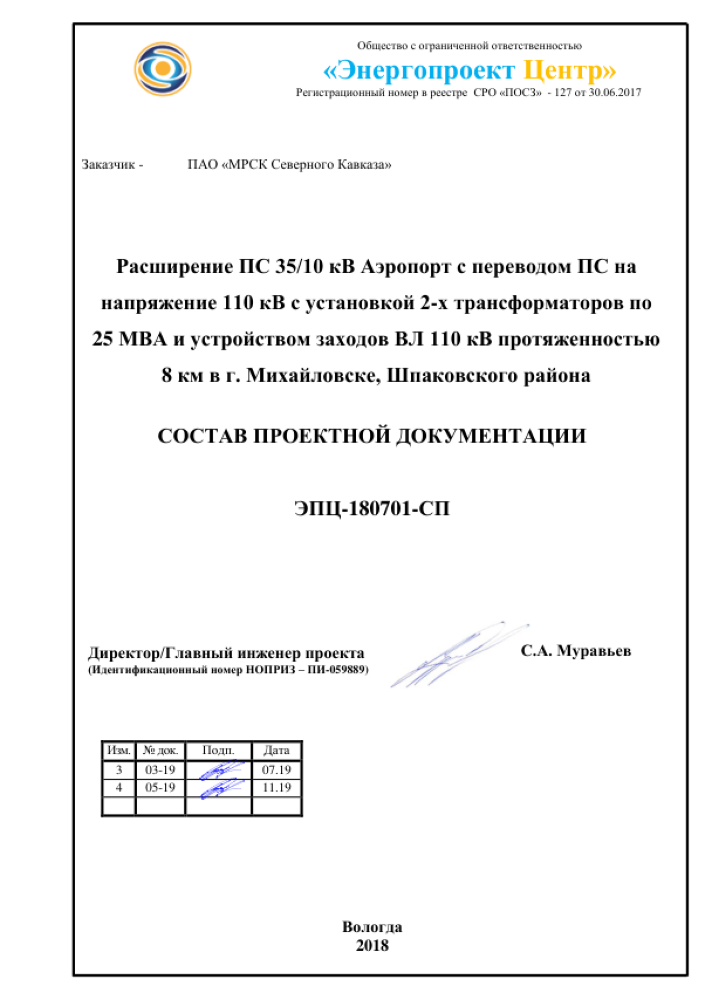

In [156]:
path = 'test_sign3.png'
image = cv2.imread('test_sign3.png')
show_image(image)

## Loader

The loader reads the file and creates a mask. 

The mask is a numpy array. The bright parts are set to 255, the rest is set to 0.

In [157]:
loader = Loader()
print(loader)


Loader
low_threshold = (0, 0, 250)
high_threshold = (255, 255, 255)



In [158]:
mask = loader.get_masks(image)
#show_image(mask)
# plt.imsave('./data/output/mask.jpeg', mask)

## Extractor

The extractor 

1. generates the regions from the mask.
2. removes the small and the big region because the signature is neither too big nor too small.

In [159]:
extractor = Extractor(outlier_weight=1, outlier_bias=50, amplfier=15, min_area_size=10)
print(extractor)


Extractor
outlier_weight = 1
outlier_bias = 50
> small_outlier_size = outlier_weight * average_region_size + outlier_bias
amplfier = 15
> large_outlier_size = amplfier * small_outlier_size
min_area_size = 10 (pixels)
> min_area_size is used to calculate average_region_size.



In [160]:
labeled_mask = extractor.extract(mask)
#show_image(labeled_mask)
#plt.imsave('labeled_mask.png', labeled_mask)

## Cropper

The cropper finds the **contours** of regions in the **labeled masks** and crop them.

In [161]:
cropper = Cropper(min_region_size=2000, border_ratio=0.1)
print(cropper)


Cropper
min_region_size = 2000
border_ratio = 0.1



In [162]:
results = cropper.run(labeled_mask)

In [163]:
len(results)

11

## Judger

The judger reads the cropped mask and identifies if it's a signature or not.

In [164]:
judger = Judger(size_ratio=[1, 4], pixel_ratio=[0.1, 0.7])
print(judger)
flag = False
for i in range(len(results)):
    res = judger.judge(results[i]['cropped_mask'])
    if res:
        flag = True
print(flag)


Judger
size_ratio = [1, 4]
pixel_ratio = [0.1, 0.7]

pixel_ratio: 1.183259911894273
pixel_ratio: 0.20237892948173322
pixel_ratio: 1.1258603736479842
True
